## **0. Preliminary Settings**

First of all, we need to mount *Google Drive* to get access to the code, which must be placed in a folder inside *Google Drive* itself

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/Colab Notebooks/DeepComedy/'
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/Models/'
results_path = '/content/drive/My Drive/Colab Notebooks/Results/'
model_name = '1. Plain RNN/1. Char-Level/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


This folder is then added to the system path so that the modules can be used inside the notebook

In [ ]:
import sys

sys.path.append(project_path + 'src')

Finally, the *Divine Comedy* is loaded and stored in a variable

In [ ]:
with open(project_path + 'res/divine_comedy.txt', 'r', encoding='ISO-8859-1') as f:
  divine_comedy = f.read()

print(divine_comedy[:231])
print('\n\n[...]\n\n')
print(divine_comedy[-266:])

INFERNO

- Canto I

Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
ché la diritta via era smarrita.

Ahi quanto a dir qual era è cosa dura
esta selva selvaggia e aspra e forte
che nel pensier rinova la paura!


[...]


ma non eran da ciò le proprie penne:
se non che la mia mente fu percossa
da un fulgore in che sua voglia venne.

A l'alta fantasia qui mancò possa;
ma già volgeva il mio disio e 'l velle,
sì come rota ch'igualmente è mossa,

l'amor che move il sole e l'altre stelle.


Also, we set both the Numpy/Keras and Tensorflow seeds to guarantee the maximal level of reproducibility

> Though, the results could still differ a little bit due to other randomized routines called during the execution and the inner stochasticity introduced by parallel computing

In [ ]:
import numpy as np
import tensorflow as tf

np.random.seed(0)
tf.random.set_seed(0)

## **1. Data Processing**

### ***1.1 Text Mark***

We use the provided function `mark` to map the original *Divine Comedy* into a marked version containing:

* a marker both at the beginning and at the end of each *cantica*

* a marker both at the beginning and at the end of each *canto*

* a marker between each couple of *tercets*

In [ ]:
from text_processing.markers import mark

divine_comedy_marked = mark(divine_comedy)
print(divine_comedy_marked[:260])
print('\n\n[...]\n\n')
print(divine_comedy_marked[-319:])

=startofcantica=
=startofcanto=
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
ché la diritta via era smarrita.
=tercet=
Ahi quanto a dir qual era è cosa dura
esta selva selvaggia e aspra e forte
che nel pensier rinova la paura!
=tercet=


[...]


=tercet=
ma non eran da ciò le proprie penne:
se non che la mia mente fu percossa
da un fulgore in che sua voglia venne.
=tercet=
A l'alta fantasia qui mancò possa;
ma già volgeva il mio disio e 'l velle,
sì come rota ch'igualmente è mossa,
=tercet=
l'amor che move il sole e l'altre stelle.
=endofcanto=
=endofcantica=


### ***1.2 The Tokenizer***

We use the provided `char_tokenizer` to tokenize the text into chars, including punctuation

> Some special tokens are reserved to the markers

In [ ]:
from text_processing.tokenizers import char_tokenizer

tokenizer = char_tokenizer(divine_comedy)
print(tokenizer.vocab_size, 'tokens:')
print()
for i, token in enumerate(sorted(tokenizer.tokens)):
  token = '\\n' if token == '\n' else token
  print(f"'{token}'", end='\n' if i in [11, 17, 39, 63] else ' ')

81 tokens:

'\n' ' ' '!' '"' ''' '(' ')' ',' '-' '.' ':' ';'
'=endofcantica=' '=endofcanto=' '=startofcantica=' '=startofcanto=' '=tercet=' '?'
'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'X' 'Z'
'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'x' 'y' 'z'
'È' 'Ë' 'Ï' 'à' 'ä' 'è' 'é' 'ë' 'ì' 'ï' 'ò' 'ó' 'ö' 'ù' 'ü' 

In [ ]:
divine_comedy_tokenized = tokenizer.encode(divine_comedy_marked)
print(len(divine_comedy_tokenized))

534798


In [ ]:
tokenized_sample = divine_comedy_tokenized[:108]
print(tokenizer.decode(tokenized_sample))

=startofcantica=
=startofcanto=
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
ché la diritta via era smarrita.
=tercet=


In [ ]:
for token in tokenized_sample:
  print(f'{token:02}', '-->', tokenizer.decode([token]))

78 --> =startofcantica=
62 --> 

76 --> =startofcanto=
62 --> 

61 --> N
42 --> e
56 --> l
70 -->  
20 --> m
42 --> e
30 --> z
30 --> z
16 --> o
70 -->  
41 --> d
42 --> e
56 --> l
70 -->  
27 --> c
17 --> a
20 --> m
20 --> m
45 --> i
18 --> n
70 -->  
41 --> d
45 --> i
70 -->  
18 --> n
16 --> o
31 --> s
33 --> t
47 --> r
17 --> a
70 -->  
07 --> v
45 --> i
33 --> t
17 --> a
62 --> 

20 --> m
45 --> i
70 -->  
47 --> r
45 --> i
33 --> t
47 --> r
16 --> o
07 --> v
17 --> a
45 --> i
70 -->  
08 --> p
42 --> e
47 --> r
70 -->  
06 --> u
18 --> n
17 --> a
70 -->  
31 --> s
42 --> e
56 --> l
07 --> v
17 --> a
70 -->  
16 --> o
31 --> s
27 --> c
06 --> u
47 --> r
17 --> a
69 --> ,
62 --> 

27 --> c
01 --> h
55 --> é
70 -->  
56 --> l
17 --> a
70 -->  
41 --> d
45 --> i
47 --> r
45 --> i
33 --> t
33 --> t
17 --> a
70 -->  
07 --> v
45 --> i
17 --> a
70 -->  
42 --> e
47 --> r
17 --> a
70 -->  
31 --> s
20 --> m
17 --> a
47 --> r
47 --> r
45 --> i
33 --> t
17 --> a
65 --> .
62 --> 

75 --> =t

### ***1.3 Building the Dataset***

In order to understand which one should be the minimal length of a window sequence so that the net could be able to clearly have an insight about the thyming scheme, we compute which one is the maximal length of an encoded verse and take the minimal length as at least four verses 

In [ ]:
# the newline token
newline = tokenizer.encode('\n')[0]

# the indices of each newline
indices = [i + 1 for i, t in enumerate(divine_comedy_tokenized) if t == newline]

# the length of each verse (or marker)
verses_lengths = [end - start for start, end in zip([0] + indices, indices +  [len(divine_comedy_tokenized)])]

# five verses (4 + tercet mark) should be enough to understand the rhyming scheme
sequences_lengths = [sum(verses_lengths[i:i+5]) for i in range(len(verses_lengths)-4)]
max(sequences_lengths)

178

Given that the ***sequence length*** should be at least *178*, we set it as *256*, then we choose a ***step_length***, namely the value that indicates how often we decide to take a sample and, finally, a ***train/validation split*** percentage

> Being the text very dense we cannot take a too small `step_length`, as it will lead both to a prohibitive training time and a lot of overfitting

> In order to avoid this behaviour but having the most possible trustworthy set of data, we choose a medium `step_length` together with a small `train_val_split`, so that (at the cost of a quite more expensive training) we could easily monitor overfitting while still using a lot of training data

In [ ]:
seq_length = 256
step_length = 32
batch_size = 64
train_val_split = 0.3

tot_samples = int((len(divine_comedy_tokenized) - seq_length) / step_length)
train_samples = round(tot_samples * train_val_split)

print('Train Samples:', train_samples)
print('  Val Samples:', tot_samples - train_samples)

Train Samples: 5011
  Val Samples: 11693


Finally, the tokenized dataset is split into windows of length `seq_length` (*+1*) sampled every `step_length` tokens and these windows are then shared into an *input sequence* and a *target sequence*, both of length `seq_length`, having an offset of one single token

In [ ]:
from tensorflow.data import Dataset

def split_input_target(chunk):
  input_sequence = chunk[:-1]
  target_sequence = chunk[1:]
  return input_sequence, target_sequence

dataset = Dataset.from_tensor_slices(divine_comedy_tokenized)
dataset = dataset.window(seq_length + 1, step_length, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(seq_length + 1))
dataset = dataset.map(split_input_target).shuffle(tot_samples, seed=0)

train_dataset = dataset.take(train_samples).batch(batch_size)
val_dataset = dataset.skip(train_samples).batch(batch_size)

In [ ]:
for input, target in dataset.take(1):
  print('INPUT:\n')
  print(tokenizer.decode(input))
  print('\n\n---------------------\n\n')
  print('TARGET:\n')
  print(tokenizer.decode(target))

INPUT:

hé tanta viltà nel core allette,
perché ardire e franchezza non hai,
=tercet=
poscia che tai tre donne benedette
curan di te ne la corte del cielo,
e 'l mio parlar tanto ben ti promette?".
=tercet=
Quali fioretti dal notturno gelo
chinati e chiusi, poi che 'l sol li 'mb


---------------------


TARGET:

é tanta viltà nel core allette,
perché ardire e franchezza non hai,
=tercet=
poscia che tai tre donne benedette
curan di te ne la corte del cielo,
e 'l mio parlar tanto ben ti promette?".
=tercet=
Quali fioretti dal notturno gelo
chinati e chiusi, poi che 'l sol li 'mbi


## **2. Model**

### ***2.1 Architecture***

The model consists of an initial *Embedding* layer that maps the tokenized characters into a dense vector which is then passed to one or two *RNN* layer(s) and, eventually, to a final *Dense* layer outputting the probabilities of each token

> The variable parameters of the model are:
> * the dimension of the *Embedding* layer
> * the kind of *RNN* (*GRU* or *LSTM*)
> * the number of units of the *RNN* layers
> * the forward and recurrent dropout rates 

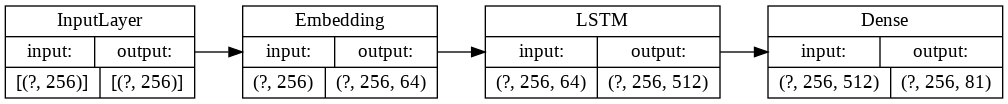

Model: "DeepComedy"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 256, 64)           5184      
_________________________________________________________________
rnn_layer_1 (LSTM)           (None, 256, 512)          1181696   
_________________________________________________________________
output_layer (Dense)         (None, 256, 81)           41553     
Total params: 1,228,433
Trainable params: 1,228,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, GRU, LSTM, Dense
from tensorflow.keras.utils import plot_model

embedding_dim = 64
rnn_type = 'LSTM'
rnn_units_1 = 512
rnn_units_2 = None
forward_dropout = 0.1
recurrent_dropout = 0.1

def rnn_layer(units, name):
  if rnn_type == 'LSTM':
    return LSTM(
      units, dropout=forward_dropout, recurrent_dropout=recurrent_dropout, name=name,
      return_sequences=True, stateful=False, recurrent_initializer='glorot_uniform'
    )
  elif rnn_type == 'GRU':
    return GRU(
      units, dropout=forward_dropout, recurrent_dropout=recurrent_dropout, name=name,
      return_sequences=True, stateful=False, recurrent_initializer='glorot_uniform'
    )

input_tensor = Input((seq_length,), dtype='int64', name='input')
embedding_tensor = Embedding(tokenizer.vocab_size, embedding_dim, name='embedding')(input_tensor)
rnn_tensor = rnn_layer(rnn_units_1, 'rnn_layer_1')(embedding_tensor)
if rnn_units_2 != None:
    rnn_tensor = rnn_layer(rnn_units_2, 'rnn_layer_2')(rnn_tensor)
output_tensor = Dense(tokenizer.vocab_size, name='output_layer')(rnn_tensor)

model = Model(input_tensor, output_tensor, name='DeepComedy')
display(plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR'))
model.summary()

We use the ***sparse categorical crossentropy*** loss to train the model

> Notice that, as we set the parameter `from_logits` equal to true, we must not use a *softmax* activation in the output layer because there is no need for the probabilities to sum up to 1

In [ ]:
from tensorflow.keras.losses import sparse_categorical_crossentropy

def loss(labels, logits):
  return sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

### ***2.2 Training***

We can now proceed with the training phase, storing every `epochs_interval` epochs the weights of the model in a file that indicates the values of its parameters

In [ ]:
from utils.validation import validation_callback
from utils.checkpoint import restore_checkpoint, checkpoint_callback

checkpoint_signature = 'seq_{} stp_{} btc_{} tvs_{} emb_{} rnn_{} ru1_{} ru2_{} fdr_{} rdr_{} epc_'.format(
    seq_length, step_length, batch_size, train_val_split, embedding_dim,
    rnn_type, rnn_units_1, rnn_units_2, forward_dropout, recurrent_dropout
)
checkpoint_directory = checkpoint_path + model_name
initial_epoch = restore_checkpoint(model, checkpoint_directory, checkpoint_signature)

epochs = 50 + initial_epoch
epochs_interval = 10
batches_interval = 20

val_callback, history = validation_callback(model, val_dataset, epochs, batches_interval)
ckp_callback = checkpoint_callback(model, checkpoint_directory, checkpoint_signature, epochs_interval)
model.fit(train_dataset, epochs=epochs, initial_epoch=initial_epoch, callbacks=[val_callback, ckp_callback], verbose=0)

model seq_256 stp_32 btc_64 tvs_0.3 emb_64 rnn_LSTM ru1_512 ru2_None fdr_0.1 rdr_0.1 epc_50.h5 restored



Here's a graphical representation of the improvement of the model, with respect both to the loss and the accuracy, across the epochs

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


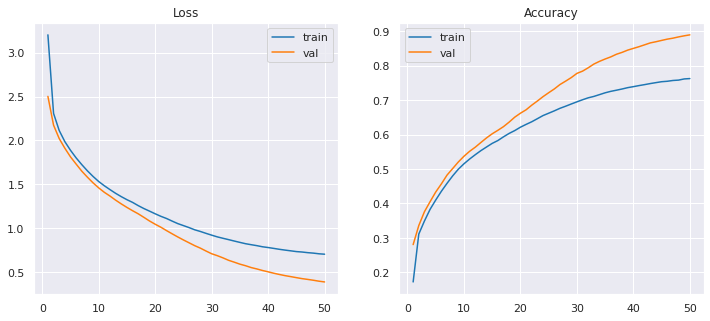

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if epochs - initial_epoch > 0:
  sns.set_style('darkgrid')
  sns.set_context('notebook')
  plt.figure(figsize=(12, 5))

  x = np.arange(epochs) + initial_epoch + 1

  plt.subplot(1, 2, 1)
  plt.plot(x, history['train loss'], label='train')
  plt.plot(x, history['val loss'], label='val')
  plt.legend()
  plt.title('Loss')

  plt.subplot(1, 2, 2)
  plt.plot(x, history['train acc'], label='train')
  plt.plot(x, history['val acc'], label='val')
  plt.legend()
  plt.title('Accuracy')

  plt.show()

## **3. Evaluation**

### ***3.1 Generation***

The generation is based on the trained model and it uses a `temperature_factor` to allow some degree of randomness

> The next token is chosen among a subset of those having a probability which is at least `1 / temperature_factor` with respect to the maximal one

> It goes without saying that a higher `temperature_factor` leads to a more explorative generation, while a lower `temperature_factor` leads to a more conservative one (in particular, with `temperature_factor = 1` the generation is completely deterministic)

In [ ]:
from tensorflow.nn import softmax
from tensorflow.random import categorical
from text_processing.markers import unmark, MARKERS

def generate(
    input_string=divine_comedy_marked[:386], # first three tercets of the comedy
    max_iterations=10000, end_marker=MARKERS['canto end'],
    temperature_factor=1.0, verbose=False
):
  # at the beginning, the generated string is the encoding of the input string
  generated_string = tokenizer.encode(input_string)
  
  for i in range(max_iterations):  
    # the input sequence is made up of the last 'seq_length' tokens of the generated string
    input_sequence = np.array([generated_string[-seq_length:]], dtype='int64')
    
    # we apply a softmax activation over the logits of the last vector of the sequence
    probabilities = softmax(model.predict(input_sequence)[0, -1]).numpy()

    # we then take a subset of possible tokens whose probability is at least 1/temperature_factor of the maximal one
    indices = np.arange(tokenizer.vocab_size)[probabilities >= probabilities.max() / temperature_factor]

    # we renormalize this subset using, again, a softmax activation
    probabilities = softmax(probabilities[probabilities >= probabilities.max() / temperature_factor]).numpy()

    # the id is randomly chosen among the indices according to the computed probabilities
    predicted_id = np.random.choice(indices, size=1, p=probabilities)[0]

    # the id is then mappend into a token from the vocabulary
    predicted_token = tokenizer.decode([predicted_id])
    if verbose:
      print(predicted_token, end='')

    # if the token coincides with the end marker, the generation is interrupted, otherwise the token is appended 
    if predicted_token == end_marker:
      break
    generated_string.append(predicted_id)
  
  # we finally return the decoded (and unmarked) string, excluding the input provided by the user
  return unmark(tokenizer.decode(generated_string)[len(input_string):])

### ***3.2 Results***

We then try different kind of temperatures and take an average evaluation, then, finally, we use the `store` utility function to store the results in a *.txt* file

In [ ]:
import os
from metrics.store import store

result_dir = results_path + model_name
os.makedirs(result_dir, exist_ok=True)

result_signature = 'seq_{} stp_{} btc_{} tvs_{} emb_{} rnn_{} ru1_{} ru2_{} fdr_{} rdr_{}.txt'.format(
    seq_length, step_length, batch_size, train_val_split, embedding_dim,
    rnn_type, rnn_units_1, rnn_units_2, forward_dropout, recurrent_dropout
)

with open(result_dir + result_signature, 'a+') as result_file:
  print('Generating Temperature 1...')
  samples = [generate(temperature_factor=1)]
  store(result_file, temperature=1, sample_texts=samples, original_text=divine_comedy)

  repetitions = 5
  for temperature in [1.5, 2, 2.5, 3, 4]:
    samples = []
    for r in range(repetitions):
      print(f'Generating Temperature {temperature} (repetition {r+1})...')
      samples.append(generate(temperature_factor=temperature))
    store(result_file, temperature, sample_texts=samples, original_text=divine_comedy)

Generating Temperature 1...
> Temperature Factor: 1
  - putative tercets --> 9.00
  - well-formed tercets --> 7.00
  - structuredness --> 0.77
  - hendecasyllabicness --> 0.80
  - rhymeness --> 0.67
  - plagiarism --> 0.67

Generating Temperature 1.5 (repetition 1)...
Generating Temperature 1.5 (repetition 2)...
Generating Temperature 1.5 (repetition 3)...
Generating Temperature 1.5 (repetition 4)...
Generating Temperature 1.5 (repetition 5)...
Generating Temperature 1.5 (repetition 6)...
Generating Temperature 1.5 (repetition 7)...
Generating Temperature 1.5 (repetition 8)...
Generating Temperature 1.5 (repetition 9)...
Generating Temperature 1.5 (repetition 10)...
> Temperature Factor: 1.5
  - putative tercets --> 51.50
  - well-formed tercets --> 38.40
  - structuredness --> 0.74
  - hendecasyllabicness --> 0.90
  - rhymeness --> 0.30
  - plagiarism --> 0.64

Generating Temperature 2 (repetition 1)...
Generating Temperature 2 (repetition 2)...
Generating Temperature 2 (repetition 3)